In [1]:
! git clone https://github.com/kendreaditya/ECG_DATA.git

Cloning into 'ECG_DATA'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.
Checking out files: 100% (9/9), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import signal
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
import time
from matplotlib import style

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = True # processing data

Running on GPU - cuda:0


Data from github
180


'\nfor ecgFile in tqdm(trainingData):\n  #ZOOM OUT\n  rnd = (np.random.randint(40)*2)+100\n  ecg = [0] * int((180-rnd)/2)\n  for x in signal.resample(ecgFile[0], rnd):\n    ecg.append(x)\n  for _ in range(int((180-rnd)/2)):\n    ecg.append(0)\n\n  trainingData.append([ecg, ecgFile[1]])\n  \n  #ZOOM IN\n  ecg = []\n  rnd = (np.random.randint(32)*2)+180\n  diff_ecg = signal.resample(ecgFile[0], rnd)\n  p1_ecg = diff_ecg[:len(diff_ecg/2)]\n  p1_ecg = p1_ecg[-90:]\n  p2_ecg = diff_ecg[len(diff_ecg/2):]\n  p2_ecg = p1_ecg[:91]\n  for x in p1_ecg:\n    ecg.append(x)\n  for x in p2_ecg:\n    ecg.append(x)\n\n  ecg = np.asarray(ecg)\n  ecg = ecg / np.amax(abs(ecg))  #ecg.append(signal.resample(ecgFile[0], rnd))\n\n  trainingData.append([ecg, ecgFile[1]])\n'

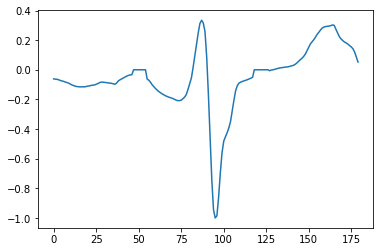

In [4]:

try:
  trainingData = np.load("ECG_DATA/trainingData.npy", allow_pickle=True)
  print("Data from github")
except:
  trainingData = np.load("drive/My Drive/trainingData.npy", allow_pickle=True)
  print("Data from google dive")
ecg = trainingData[0][0]
print(len(ecg))
plt.plot(ecg)
'''
for ecgFile in tqdm(trainingData):
  #ZOOM OUT
  rnd = (np.random.randint(40)*2)+100
  ecg = [0] * int((180-rnd)/2)
  for x in signal.resample(ecgFile[0], rnd):
    ecg.append(x)
  for _ in range(int((180-rnd)/2)):
    ecg.append(0)

  trainingData.append([ecg, ecgFile[1]])
  
  #ZOOM IN
  ecg = []
  rnd = (np.random.randint(32)*2)+180
  diff_ecg = signal.resample(ecgFile[0], rnd)
  p1_ecg = diff_ecg[:len(diff_ecg/2)]
  p1_ecg = p1_ecg[-90:]
  p2_ecg = diff_ecg[len(diff_ecg/2):]
  p2_ecg = p1_ecg[:91]
  for x in p1_ecg:
    ecg.append(x)
  for x in p2_ecg:
    ecg.append(x)

  ecg = np.asarray(ecg)
  ecg = ecg / np.amax(abs(ecg))  #ecg.append(signal.resample(ecgFile[0], rnd))

  trainingData.append([ecg, ecgFile[1]])
'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=180).
  """


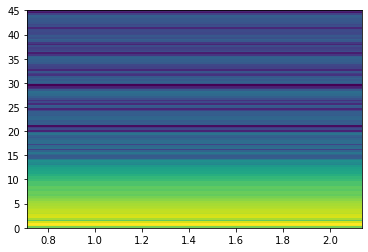

In [0]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plot
y = np.array([i for i in range(180)])
plot.specgram(trainingData[0][0], Fs = 90)
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 180, 5, padding=2) 
        self.conv2 = nn.Conv1d(180, 150, 5, padding=2) 
        self.conv3 = nn.Conv1d(150, 120, 5, padding=2)
        self.conv4 = nn.Conv1d(120, 90, 5, padding=2)
        self.conv5 = nn.Conv1d(90, 60, 5, padding=2)

        x = torch.randn(1,1,180).view(-1,1,180)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 180)
        self.fc2 = nn.Linear(180, 4)

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = F.max_pool1d(F.relu(self.conv4(x)), 3)
        x = F.max_pool1d(F.relu(self.conv5(x)), 3)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


net = Net().to(device)
print(net)

Net(
  (conv1): Conv1d(1, 180, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(180, 150, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(150, 120, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(120, 90, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5): Conv1d(90, 60, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=60, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=4, bias=True)
)


In [6]:
import torch.optim as optim

#optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)

X = torch.Tensor([i[0] for i in trainingData])
y = torch.Tensor([i[1] for i in trainingData])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

train_data = trainingData[:-val_size]

test_data = trainingData[-val_size:]

print(len(train_X), len(test_X))

6600
59400 6600


In [0]:
class training():
  optimizer = optim.Adam(net.parameters(), lr = 0.001)#, weight_decay=1e-5)
  loss_function = nn.CrossEntropyLoss()#weight=1/torch.Tensor(list(Data_PreProcessing.dataCount.values())))
  PATH = "/content/drive/My Drive/ECG_MODELS/"

  def train(self):
    net = Net().to(device).apply(self.weight_reset)
    layers, params = self.net_info(net)
    MODEL_NAME = f"layers-{layers}_parms-{str(params)[1:-1].replace(', ', '_')}_model-{int(time.time())}"
    BATCH_SIZE = 7500
    EPOCHS = 100

    with open(self.PATH+"data/"+f"{MODEL_NAME}.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, len(train_X), BATCH_SIZE):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,180)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = self.fwd_pass(batch_X, batch_y, train=True)
                
                if i % 50 == 0:
                    val_acc, val_loss = self.test(size=100)
                    f.write(f"{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")

    torch.save(net, self.PATH+"model_params/"+f'{MODEL_NAME}.pt')

    model_data = open(self.PATH+"model_data/"+f"{MODEL_NAME}.txt", "w")
    model_data.write(str(net))
    model_data.write("/n")
    model_data.write(str(self.optimizer))
    model_data.write("/n")
    model_data.write(str(self.loss_function))
    model_data.close()

    return MODEL_NAME, EPOCHS

  def fwd_pass(self, X, y, train=False):
    if train:
      net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss_function = nn.CrossEntropyLoss().to(device)
    loss = loss_function(outputs, torch.argmax(y, 1))
    if train:
      loss.backward()
      self.optimizer.step()
    return acc, loss

  def test(self,size=100):
      X, y = test_X[:size], test_y[:size]
      val_acc, val_loss = self.fwd_pass(X.view(-1, 1, 180).to(device), y.to(device))
      return val_acc, val_loss

  def net_info(self, net):
    params = []
    for layers, m in enumerate(net.modules()):
      params.append(int(''.join(filter(lambda x: x.isdigit(),str((str(m).split(',')[1]))))))

    return layers, params

  def weight_reset(self, m):
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
          m.reset_parameters()

In [0]:
def graph_data(MODEL_NAME, EPOCHS):
  style.use("ggplot")
  PATH = "/content/drive/My Drive/ECG_MODELS/"

  contents = open(PATH+"data/"+f"{MODEL_NAME}.log", "r").read().split("\n")
  times = []
  accuracies = []
  losses = []
  mean_loss = []
  mean_acc = []
  val_accs = []
  val_losses = []
  
  contents = (c.split(",") for c in contents[:-1])
  for temp in list(contents):

    times.append(float(temp[0]))
    accuracies.append(float(temp[1]))
    losses.append(float(temp[2]))
    
    val_accs.append(float(temp[3]))
    val_losses.append(float(temp[4]))


  print("Best Valid Accuracy:", max(val_accs))
  times = (np.asarray(times) - min(times))
  times = times/np.amax(times)
  times = times * EPOCHS
  fig = plt.figure(figsize=(20, 10))
  ax1 = plt.subplot2grid((2,1), (0,0))
  ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

  ax1.set_ylim([0,1])
  ax1.set_ylabel('Accuracy (0.0-1.0)')
  ax1.plot(times, accuracies, label="Training Set Accuracy")
  ax1.plot(times, val_accs, label="Validation Set Accuracy")
  ax1.plot(times, abs(np.array(val_accs)-np.array(accuracies)), label="Δ Accuracy (between Training & Validation Set)")
  ax1.legend(loc=2)

  ax2.set_ylim([0,2])
  ax2.set_ylabel('Loss (0.0-2.0)')
  ax2.set_xlabel(f'Epochs (0-{EPOCHS})')
  ax2.plot(times, losses, label="Training Set Loss")
  ax2.plot(times, val_losses, label="Validation Set Loss")
  ax2.plot(times, abs(np.array(val_losses)-np.array(losses)), label="Δ Loss (between Training & Validation Set)")
  ax2.legend(loc=2)
  plt.savefig(PATH+"graphs/"+MODEL_NAME)
  plt.show()

100%|██████████| 100/100 [16:24<00:00,  9.84s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Best Valid Accuracy: 0.6


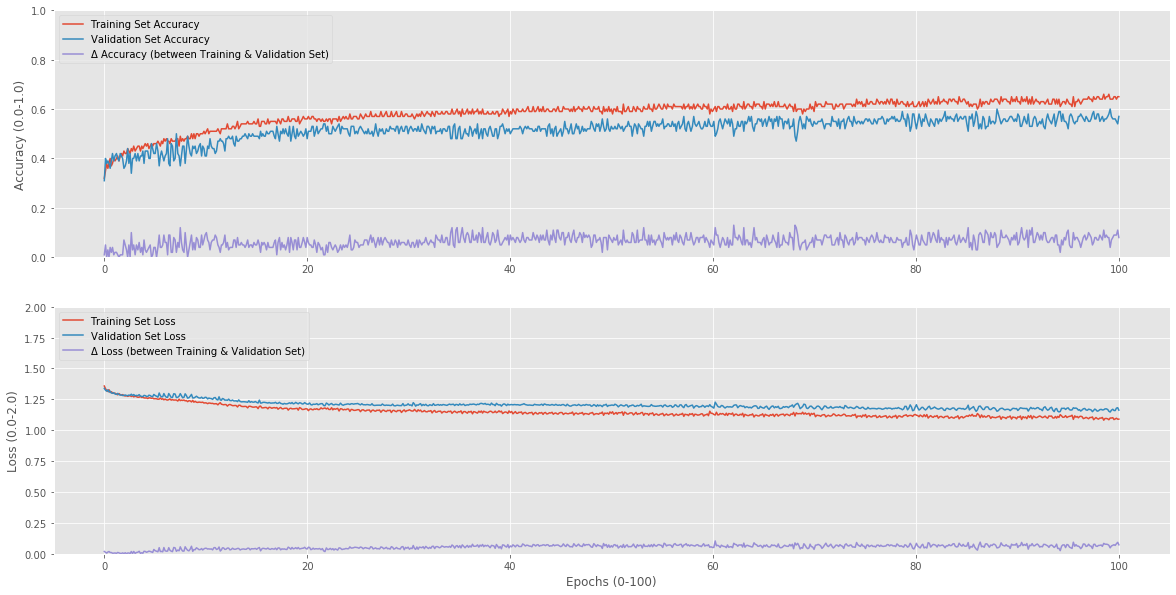

In [11]:
train_model = training()
MODEL_NAME, EPOCHS = train_model.train()
graph_data(MODEL_NAME, EPOCHS)